#Categorical DQN for MS-Pacman from RAM

In this notebook I will train a [Categorical Deep Q-Network ](https://arxiv.org/pdf/1707.06887.pdf) to play the Atari 2600 game MsPacman using the reinforcement learning library [TF-Agents](https://www.tensorflow.org/agents). <br> Using the [OpenAI Gym environment](https://gym.openai.com/envs/MsPacman-v0),  the agent can be trained using as a input the RAM of the Atari machine consisting of 128 bytes. 

##Install and import dependencies

In [ ]:
!sudo apt-get install -y xvfb ffmpeg
!pip install -q 'imageio==2.4.0'
!pip install -q pyvirtualdisplay
!pip install -q tf-agents==0.7.1
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import csv
import tensorflow as tf

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_atari
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.train.utils import strategy_utils
from tf_agents.train.utils import train_utils
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import categorical_q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.policies import policy_saver

from tf_agents.networks.encoding_network import EncodingNetwork
import time
from scipy.stats import norm

tf.compat.v1.enable_v2_behavior()


# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()


Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 784 kB in 1s (1,228 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a c

##Hyperparameters





I use a categorical Q-network projecting into an histogram with 101 bins uniformly spread between 0 and 500. This means that any value above 500 will be included in the last bin. This hard cutoff biases the network into ignoring very long term returns and thus decreasing the variance coming from uncertainty of returns in the far future. Having 101 bins means that the bis size is around 5 points, this eliminates small fluctuactions (coming again from returns far in the future since returns are discounted) but could potentially leave the agent uncertain over which action to choose when all have a small expected discounted return (such as can happen at the end of the level when few points are still available). \\
The parameters of the network are matched to the ones of the target network every 10000 steps to give enough time to the network to evaluate the expected return of the actions before updating the parameters. \\
The agent collects 768 steps every iteration and consider the bootsrapped returns of 5 consequent steps. The buffer will store 3 millions steps to keep training more stable. \\
In order to maintain both a small batch size and efficient sample (re)usage each iteration will consist of 16 epochs with minibatch size 64 (as opposed to a single epoch with batch size 1024)

In [ ]:
continue_training=True 

#agent hyperparameters
target_update_period=10000     #No of training batches before updating the target network 
target_update_tau=1    #Magnitude of the update of the target network weights
gradient_clipping=1.
reward_scale_factor=1. 
num_atoms=101
min_q_value=0
max_q_value=500 #hard cutoff on the maximum reward to consider for each action
n_step_update=5 #number of bootstrap steps for TD learning 

#Replay buffer and initialization
initial_collect_steps = 10000
replay_buffer_max_length = 3000000  # @param {type:"integer"}

#Training loop
epochs_per_iteration=16 #number of training epochs between data collection steps (do not change it after initialization, otherwise the train step counter will give problems)
exploration_iterations=10000 #steps after which stop the updating of training parameters
final_iterations_treshold=30000
plot_data_interval=(exploration_iterations//10)*epochs_per_iteration
plot_data_episodes=100
update_step=(exploration_iterations//10)
num_iterations=(update_step//2) #it should better be set to a divisor of update_step
collect_steps_per_iteration = 128*(n_step_update+1) #Each data point will be made out of n_step_update+1 steps
batch_size = 64  
log_interval = (num_iterations//20)  # @param {type:"integer"}
num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = (num_iterations//2) # @param {type:"integer"}
checkpoint_iterations=(num_iterations//2) #it better should be set to a divisor of num_iterations
video_saving_interval=5000*epochs_per_iteration





## Learning scheduler (*It only updates at reruns*)

The following code implements a training routine which will be updated at each rerun. This is because due to the limitations of Google Colab it was more convenient to train the model for few iterations per run and then restart the notebook. \\
There are two phases dictated by `exploration_iterations`: in the first phase the parameter `epsilon_greedy` is slowly decreased to ensure more exploration in the early phase of the training. The discount factor $\gamma$ is slowly increased so that in the initial phase the model focus more on immediate reward rather than long term reward. In the second phase the discount factor is fixed while the `epsilon_greedy` oscillates so that the model has enough time to evaluate the current policy but periodically gets more diverse samples. \\
The learning rate is modulated with a triangular learning scheduler and is bigger in the first phase of the training.

  

In [ ]:
if not continue_training:
    np.save('/content/drive/MyDrive/Reinforcement learning/Pacman DQN v1/counter.npy',0) #Only to reset the step counter at the beginning of the training process

train_steps=np.load('/content/drive/MyDrive/Reinforcement learning/Pacman DQN v1/counter.npy')
print(train_steps)
train_steps=train_steps//epochs_per_iteration
print('Current train iteration:', train_steps)
print('Updated step interval:', update_step)
min_epsilon_greedy=0.1
if train_steps<exploration_iterations:
  gamma=0.9+(train_steps//update_step)*0.01
  epsilon_greedy=0.9-(train_steps//update_step)*0.1 #Slowly annealing the epsilon_greedy parameter for collect policy during training
  if epsilon_greedy<min_epsilon_greedy:
      epsilon_greedy=min_epsilon_greedy
  if (train_steps//num_iterations)%4==0: #implement a triangular scheduler for the learning rate
       learning_rate =1e-5
  elif (train_steps//num_iterations)%4==2:
       learning_rate =1e-3
  else:
       learning_rate =1e-4 
else:
  gamma=0.995
  if (train_steps//num_iterations)%4==0: #implement a static triangular scheduler for the learning rate and greedy policy
       learning_rate =1e-6
       epsilon_greedy=0.01

  elif (train_steps//num_iterations)%4==2:
       learning_rate =1e-4 
       epsilon_greedy=0.1

  else:
       learning_rate =1e-5 
       epsilon_greedy=0.05





print('Current learning parameters: \n -epsilon_greedy=',epsilon_greedy,'\n -gamma=', gamma, '\n -learning_rate=', learning_rate)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)


1256000
Current train iteration: 78500
Updated step interval: 1000
Current learning parameters: 
 -epsilon_greedy= 0.05 
 -gamma= 0.995 
 -learning_rate= 1e-05


## Environment setup

I use the RAM gym environment: https://gym.openai.com/envs/MsPacman-v0. \\
 The input of the agent will thus be directly the 128 byte of the atari machine. This poses several challenges with respect to using the visual of the screen as an input as the information in the RAM can be encoded in a complicated way. In particulare there are no simple "geometric" features that we can exploit with a CNN architecture to determine the shape of the maze or the positions of ghosts. \\
The environment also repeat each action taken by the agent for a random number of frames in the range {2,3,4} thus effectively introducing stochasticity in the environment and making learning more challenging. \\
A further challenge posed by this environments is that the episode ends when the agent loses all 3 lives, this makes episodes longer than just considering each life separatly because the agent must consider longer term rewards. In particular after having lost one life there is no penalty and the agent can continue to collect points (unless it was the last life), making more difficult for the agent to learn to avoid being eaten by the ghosts.

In [ ]:
env_name =  "MsPacman-ram-v0"             #The state will be specified directly by the 128 byte RAM of the atari machine!
env = suite_gym.load(env_name)
env.reset()
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Reward Spec:')
print(env.time_step_spec().reward)
print('Action Spec:')
print(env.action_spec())
print('Reward spec')



Observation Spec:
BoundedArraySpec(shape=(128,), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=8)
Reward spec


Time step:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([  0, 112, 114, 115,   0,   3,  88,  88,  88,  88,  88,   0,  80,
        80,  80,  50,  98,   0,   0,   3,   0,   0,   1,   0,   0,   1,
         6,   6, 198,   4,  71,   0,  45,   1,   0, 198, 198,   0,   0,
         0,   0,  16,  52,   0,   0, 120,   0, 100, 130,   0,   0, 134,
         1, 222,   0,   1,   3,   0,   6,  80, 255, 255,   0, 255, 255,
        80, 255, 255,  80, 255, 255,  80, 255, 255,  80, 191, 191,  80,
       191, 191,  80, 191, 191,  80, 255, 255,  80, 255, 255,  80, 255,
       255,  80, 255, 255,   0, 255, 255,  80, 255, 255,  20, 223,  43,
       217, 123, 217, 123, 217, 123, 217, 123, 217, 123, 217, 221,   0,
        63,   0,   0,   0,   0,   0,   2,  66, 240, 146, 215], dtype=uint8))
After 100 time step:
TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation

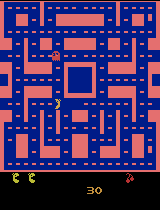

In [ ]:
#Try out one action and visualize state
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(3, dtype=np.int32)

for i in range(100):
  next_time_step = env.step(action)

print('After 100 time step:')
print(next_time_step)
PIL.Image.fromarray(env.render())


In [ ]:
#Defining train and evaluation environment and wrapping them into a TF environment
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


##Network and agent initialization

The agent is initialized using built-in tf agents methods. The chosen architecture (after a small set of experiments) for the categorical Q-network consists of 4 fully connected layers with Exponential Linear Unit activation. 

In [ ]:
#Network and agent
fc_layer_params = (512,256,256,256)
activation=tf.keras.layers.ELU(alpha=0.1)


preprocessing_layers=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
cat_q_net =categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        fc_layer_params=fc_layer_params,
        preprocessing_layers=preprocessing_layers, #Normalize input
        activation_fn=activation,
        num_atoms=num_atoms,
        )
 
train_step = train_utils.create_train_step()

train_step_counter = tf.Variable(0)

agent = categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        categorical_q_network=cat_q_net,
        min_q_value=min_q_value,
        max_q_value=max_q_value,
        n_step_update= n_step_update,
        optimizer=optimizer,
        train_step_counter=train_step_counter,
        target_update_period=target_update_period, 
        target_update_tau=target_update_tau,
        epsilon_greedy=epsilon_greedy,   
        reward_scale_factor=reward_scale_factor,
        gamma=gamma,    
        gradient_clipping=gradient_clipping)

agent.initialize()

eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())


cat_q_net.summary()

Model: "CategoricalQNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CategoricalQNetwork (QNetwor multiple                  562573    
Total params: 562,573
Trainable params: 562,573
Non-trainable params: 0
_________________________________________________________________


##Visualize behavior of a random agent

Visualizing behavior and performance of an agent acting randomly.  

In [ ]:
#average return metric
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=3, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)


print('Random agent average return:', compute_avg_return(eval_env, random_policy, num_episodes=10))

create_policy_eval_video(random_policy, "random agent")

Random agent average return: 216.0


##Replay buffer and data collector

In [ ]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)


collect_driver = dynamic_step_driver.DynamicStepDriver(
      train_env,
      agent.collect_policy,
      observers=[replay_buffer.add_batch],
      num_steps=collect_steps_per_iteration)




print('Initial samples:', replay_buffer.num_frames())

dataset = replay_buffer.as_dataset(
      num_parallel_calls=3, 
      sample_batch_size=batch_size, 
      num_steps=n_step_update + 1,
    ).prefetch(1).shuffle(100000)

iterator=iter(dataset)

Initial samples: tf.Tensor(0, shape=(), dtype=int64)
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Checkpointer

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Reinforcement learning/Pacman DQN v1'
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=2,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=train_step_counter
)

##Training Loop

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
Replay buffer samples: tf.Tensor(3000000, shape=(), dtype=int64)
step = 1256000: Average Return = 3523.0
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Elapsed time=0:4:15, ETA=1:20:45; step = 1256400, loss = 3.3798155784606934
Elapsed time=0:7:59, ETA=1:11:55; step = 1256800, loss = 3.3096554279327393
Elapsed time=0:11:45, ETA=1:6:35; step = 1257200, loss = 3.235252857208252
Elapsed time=0:15:28, ETA=1:1:54; step = 1257600, loss = 3.356107234954834
Elapsed time=0:19:9, ETA=0:57:29; step = 1258000, loss = 3.4301929473876953
Elapsed time=0:22:51, ETA=0:53:21; step = 1258400, loss = 3.4346909523010254
Elapsed time=0:26:34, ETA=0:49:21; step = 1258800, loss = 3.315609931945801
Elapsed time=0:30:17, ETA=0:45:25; step = 1259200, loss = 3.1967673301696777
Elapsed time=0:33:59, ETA=0:41:33; step = 1259600, loss = 3.348989486694336
Elapsed time=0:37:43, ETA=0:37:43; step = 1260000, loss = 3.240053176879883
step = 1260000: Average Return = 3726.0
Checkpoint saved
Elapsed time=0:43:8, ETA=0:35:18; step = 1260400, loss = 3.4771175384521484
Elapsed time=0:46:51, ETA=0:31:14; step = 1260800, loss = 3.247269630432129
Elapsed time=0:50:39, ETA=0:27:

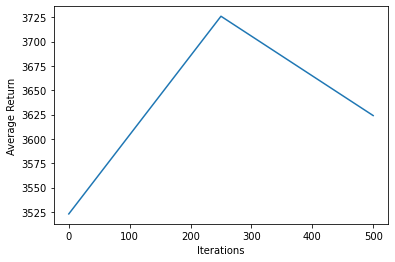

In [ ]:
def return_and_lenght_mean_std(environment, policy, num_episodes=100):
  """ Computes mean and standard deviation for both lenght and total return. 
      Used as a metric to evaluate training and testing agents."""
  returns =[]
  lenght=[]
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    n_steps=0
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
      n_steps+=1
    returns.append(episode_return.numpy()[0])
    lenght.append(n_steps)
  mean_return=np.mean(returns)
  returns_std=np.std(returns)
  mean_lenght=np.mean(lenght)
  lenght_std=np.std(lenght)
  return mean_return, returns_std, mean_lenght, lenght_std

#Fills the replay buffer with random trajectories at the beginning of the training
if not continue_training:
    dynamic_step_driver.DynamicStepDriver(
      train_env,
      agent.collect_policy,
      observers=[replay_buffer.add_batch],
      num_steps=initial_collect_steps).run()
    train_checkpointer.save(train_step_counter)
else:
    train_checkpointer.initialize_or_restore()
    global_step = tf.compat.v1.train.get_global_step()
#TRAIN
try:
  %%time
except:
  pass
 
 
print('Replay buffer samples:', replay_buffer.num_frames())
 
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)
 

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
print('step = {0}: Average Return = {1}'.format(agent.train_step_counter.numpy(), avg_return))
 
start_time = time.time()
for counter in range(1,num_iterations+1):
    # Collect a few steps using collect_policy and save to the replay buffer.
    collect_driver.run()
    # Sample a batch of data from the buffer and update the agent's network.
    for _ in range(epochs_per_iteration):
      experience, unused_info = next(iterator)
      train_loss = agent.train(experience).loss
 
    step = agent.train_step_counter.numpy()
 
    if counter % log_interval == 0:
      current_time=time.time()
      elapsed_time=current_time-start_time
      ETA=(num_iterations-counter)/(counter/elapsed_time)
      print('Elapsed time={0}:{1}:{2}, ETA={3}:{4}:{5}; step = {6}, loss = {7}'.format(int(elapsed_time//3600),
                                                    int((elapsed_time % 3600)//60), int(elapsed_time % 60), int(ETA//3600),
                                                    int((ETA % 3600)//60), int(ETA % 60), step, train_loss))
 
    if counter % eval_interval == 0: #Visualize current value for the metrics
      avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
      print('step = {0}: Average Return = {1}'.format(step, avg_return))
      returns.append(avg_return)
 
    if counter % checkpoint_iterations==0: #Saves checkpointed periodically
      train_checkpointer.save(train_step_counter)
      np.save('/content/drive/MyDrive/Reinforcement learning/Pacman DQN v1/counter.npy',step)
      print('Checkpoint saved')
    if step % video_saving_interval==0:
      create_policy_eval_video(agent.policy, "/content/drive/MyDrive/Reinforcement learning/Pacman DQN v1/trained_agent_step_{}".format(step))

    if step % plot_data_interval==0:
      mean_return, returns_std, mean_lenght, lenght_std= return_and_lenght_mean_std(eval_env, agent.policy, num_episodes=plot_data_episodes)
      print('Average return:', mean_return, ' Standard deviation:', returns_std,'\n Mean lenght:', mean_lenght, 'Standard deviation:', lenght_std)   
      with open('/content/drive/MyDrive/Reinforcement learning/Pacman DQN v1/log.csv', mode='a') as log:
          log_writer = csv.writer(log, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
          log_writer.writerow([step,mean_return, returns_std, mean_lenght, lenght_std])

#iterations = range(0, num_iterations + 1, eval_interval)
#plt.plot(iterations, returns)
#plt.ylabel('Average Return')
#plt.xlabel('Iterations')
 
train_checkpointer.save(train_step_counter)
np.save('/content/drive/MyDrive/Reinforcement learning/Pacman DQN v1/counter.npy',step)
print('Checkpoint saved')

##Evaluation and visualization of the results

Let's visualize the history of agent's performance.

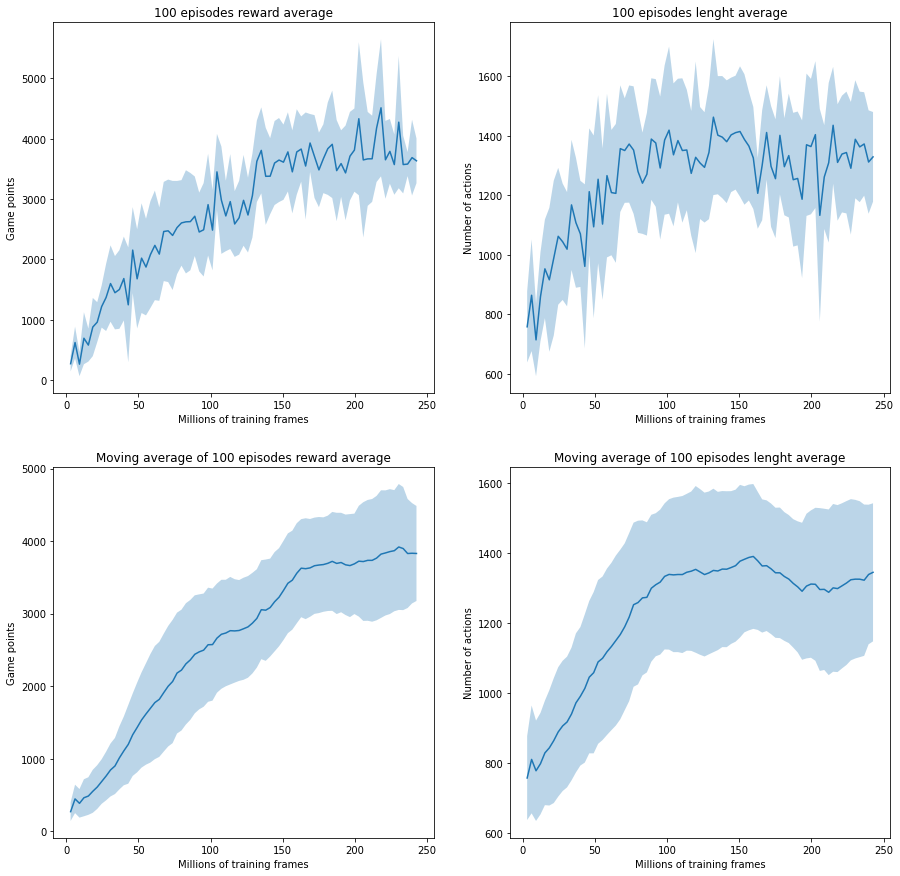

In [ ]:
def moving_average(array, steps):
    moving_avg=np.empty(array.shape)
    for i in range(array.shape[0]):
        if i<steps:
          history=array[0:(i+1)]
          moving_avg[i]=np.mean(history)
        else:
          history=array[i-steps:(i+1)]   
          moving_avg[i]=np.mean(history)
    return moving_avg


with open('/content/drive/MyDrive/Reinforcement learning/Pacman DQN v1/log.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    step_number=[]
    reward_avg=[]
    reward_std=[]
    lenght_avg=[]
    lenght_std=[]

    for row in csv_reader:
      step_number.append((float(row[0])/epochs_per_iteration)*(collect_steps_per_iteration*batch_size/(epochs_per_iteration*1e6))) #transform step number into million of frames number
      reward_avg.append(float(row[1]))
      reward_std.append(float(row[2]))
      lenght_avg.append(float(row[3]))
      lenght_std.append(float(row[4]))

reward_avg=np.asarray(reward_avg)
reward_std=np.asarray(reward_std)
lenght_avg=np.asarray(lenght_avg)
lenght_std=np.asarray(lenght_std)

moving_steps=10
moving_reward_avg=moving_average(reward_avg,moving_steps)
moving_reward_std=moving_average(reward_std,moving_steps)
moving_lenght_avg=moving_average(lenght_avg,moving_steps)
moving_lenght_std=moving_average(lenght_std,moving_steps)

fig, axs=plt.subplots(2,2, figsize=(15,15))
axs[0,0].plot(step_number,reward_avg)
axs[0,0].fill_between(step_number, reward_avg-reward_std, reward_avg+reward_std, alpha=0.3)
axs[0,0].set_ylabel('Game points')
axs[0,0].set_xlabel('Millions of training frames')
axs[0,0].set_title('{} episodes reward average'.format(plot_data_episodes))
axs[0,1].plot(step_number,lenght_avg)
axs[0,1].fill_between(step_number, lenght_avg-lenght_std, lenght_avg+lenght_std, alpha=0.3)
axs[0,1].set_ylabel('Number of actions')
axs[0,1].set_xlabel('Millions of training frames')
axs[0,1].set_title('{} episodes lenght average'.format(plot_data_episodes))
axs[1,0].plot(step_number,moving_reward_avg)
axs[1,0].fill_between(step_number, moving_reward_avg-moving_reward_std, moving_reward_avg+moving_reward_std, alpha=0.3)
axs[1,0].set_ylabel('Game points')
axs[1,0].set_xlabel('Millions of training frames')
axs[1,0].set_title('Moving average of {} episodes reward average'.format(plot_data_episodes))
axs[1,1].plot(step_number, moving_lenght_avg)
axs[1,1].fill_between(step_number, moving_lenght_avg-moving_lenght_std, moving_lenght_avg+moving_lenght_std, alpha=0.3)
axs[1,1].set_ylabel('Number of actions')
axs[1,1].set_xlabel('Millions of training frames')
axs[1,1].set_title('Moving average of {} episodes lenght average'.format(plot_data_episodes))
plt.show()


From the plots it seems that the agents could still benefits from some more training.

Visualization of the behavior of the trained agent

In [ ]:
create_policy_eval_video(agent.policy, "trained-agent")

Since there is stochasticity in the environment (as the random frame skip discussed above),  let's visualize histograms containing returns and lenghts for 100 evaluation episodes 

Mean return: 3713.1 Standard deviation: 589.98083
Mean lenght: 1324.83 Standard deviation: 158.50148611290683
returns [3660.0, 3190.0, 3340.0, 3620.0, 3350.0, 3470.0, 3570.0, 3460.0, 4920.0, 3800.0, 3830.0, 3900.0, 4360.0, 3750.0, 3730.0, 3730.0, 3570.0, 3750.0, 4480.0, 3080.0, 3590.0, 3590.0, 2980.0, 4970.0, 3680.0, 3690.0, 3420.0, 3560.0, 3470.0, 3650.0, 3560.0, 3200.0, 2950.0, 4650.0, 3420.0, 4530.0, 3670.0, 3260.0, 3740.0, 3680.0, 3400.0, 3470.0, 3640.0, 3770.0, 3550.0, 4410.0, 3740.0, 3480.0, 3660.0, 3460.0, 4570.0, 3430.0, 3660.0, 3400.0, 4940.0, 3600.0, 7820.0, 3700.0, 3340.0, 3670.0, 4040.0, 3680.0, 3460.0, 3980.0, 3710.0, 3550.0, 3200.0, 3820.0, 3540.0, 3590.0, 3630.0, 3600.0, 3510.0, 3560.0, 3650.0, 3690.0, 3600.0, 3440.0, 3420.0, 3090.0, 3410.0, 3420.0, 3610.0, 3170.0, 3420.0, 3560.0, 3600.0, 3410.0, 3980.0, 3800.0, 4070.0, 4820.0, 3510.0, 3470.0, 4870.0, 2900.0, 3100.0, 3730.0, 3670.0, 3500.0]


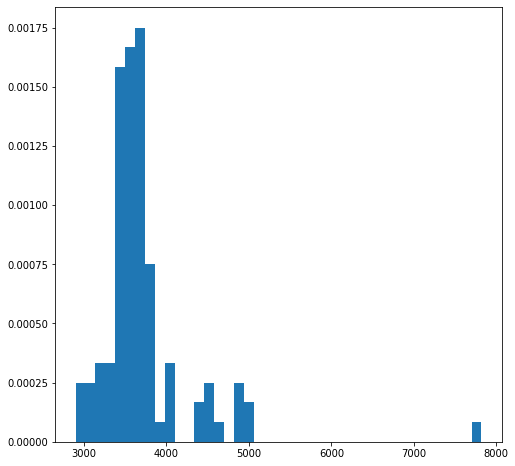

Steps per episode


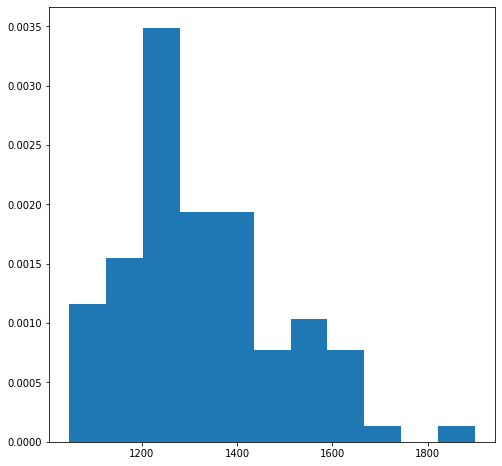

In [ ]:
def return_histo(environment, policy, num_episodes=100):

  returns =[]
  lenght=[]
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    n_steps=0
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
      n_steps+=1
    returns.append(episode_return.numpy()[0])
    lenght.append(n_steps)
    mean_return=np.mean(returns)
    returns_std=np.std(returns)
    mean_lenght=np.mean(lenght)
    lenght_std=np.std(lenght)
  print("Mean return:", mean_return,"Standard deviation:", returns_std)
  print("Mean lenght:", mean_lenght,"Standard deviation:", lenght_std)
  returns_plot_range=np.arange(mean_return-4*returns_std, mean_return+4*returns_std, returns_std/100)
  lenght_plot_range=np.arange(mean_lenght-4*lenght_std, mean_lenght+4*lenght_std, lenght_std/100)

  print('returns', returns)  
  fig = plt.figure(figsize=(8,8))
  ax  = fig.add_subplot(111)
  ax.hist(returns,density=True, bins='auto')
  plt.show()

  print('Steps per episode')
  fig = plt.figure(figsize=(8,8))
  ax  = fig.add_subplot(111)
  ax.hist(lenght, density=True, bins='auto')
  plt.show()

return_histo(eval_env, eval_policy, num_episodes=100) 

In [ ]:
train_checkpointer.save(train_step_counter)
np.save('/content/drive/MyDrive/Reinforcement learning/Pacman DQN v1/counter.npy',step)


Export the policy of the trained agent

In [ ]:
from tf_agents.policies import policy_saver

policy_dir='/content/drive/MyDrive/Reinforcement learning/Pacman DQN v1/Saved policy'
Policy_saver=policy_saver.PolicySaver(eval_policy)
Policy_saver.save(policy_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Reinforcement learning/Pacman DQN v1/Saved policy/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Reinforcement learning/Pacman DQN v1/Saved policy/assets


Test for the exported policy

In [ ]:
saved_policy = tf.compat.v2.saved_model.load(policy_dir)
create_policy_eval_video(saved_policy, "trained-agent")